In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
import regression_tools as rt

In [2]:
#脱ブタン塔のプロセスデータを読み込む
df = pd.read_csv('debutanizer_data.csv')

In [3]:
#時系列データなので、実務データを想定しindexに時刻を割り当てる
# 開始日時を指定
start_datetime = '2024-01-01 00:00:00'
# DataFrameの長さを取得
n = len(df)
# 日時インデックスを生成（1分間隔）
date_index = pd.date_range(start=start_datetime, periods=n, freq='T')
# DataFrameのインデックスを新しい日時インデックスに設定
df.index = date_index

# 目的変数の測定時間を考慮（5分間）
df['y'] = df['y'].shift(5)

#yがnanとなる期間のデータを削除
df = df.dropna()

#説明変数と目的変数にわける
X = df.iloc[:, :-1]
y = df['y']

#時間遅れ変数を作成
delay_number = 18
X_with_delays = pd.DataFrame()
for col in X.columns:
    col_name = f"{col}_delay_{delay_number}"
    X_with_delays[col_name] = X[col].shift(delay_number)

# 時間遅れ変数とｙのデータフレームを作成
X_with_delays['y'] = y
X_with_delays = X_with_delays.dropna()

# 目的変数と説明変数に分割
X = X_with_delays.iloc[:, :-1]
y = X_with_delays['y']

In [4]:
# データの標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1)).ravel()
y_scaled = pd.Series(y_scaled)

In [5]:
X_scaled

,x1_delay_18,x2_delay_18,x3_delay_18,x4_delay_18,x5_delay_18,x6_delay_18,x7_delay_18
2024-01-01 00:23:00,-0.163676,-0.590273,0.892745,0.857260,0.771549,1.156207,1.136319
2024-01-01 00:24:00,-0.168683,-0.239066,0.891734,0.833266,0.855828,1.399807,1.334462
2024-01-01 00:25:00,-0.173685,0.076366,0.889604,0.809270,0.812254,1.121557,1.341855
2024-01-01 00:26:00,-0.192245,-0.492364,0.829795,0.785274,0.749488,1.155205,1.151456
2024-01-01 00:27:00,-0.296782,-0.097469,0.871382,0.761278,0.686722,1.167221,1.151456
...,...,...,...,...,...,...,...
2024-01-02 15:49:00,1.289208,0.335617,-0.753561,-2.487014,0.390845,1.086586,0.897593
2024-01-02 15:50:00,1.647308,0.385259,-0.734625,-2.527335,0.778163,1.402483,1.149708
2024-01-02 15:51:00,2.005413,0.499402,-0.349883,-2.567658,1.176820,1.854900,1.464096
2024-01-02 15:52:00,2.131759,0.300708,0.170701,-2.607979,1.047955,1.620386,1.356662


In [20]:
# ランダムで作成した説明変数を10個追加
np.random.seed(0)
for i in range(1, 11):
    X_scaled[f'random_var{i}'] = np.random.randn(len(X_scaled))
X_scaled

,x1_delay_18,x2_delay_18,x3_delay_18,x4_delay_18,x5_delay_18,x6_delay_18,x7_delay_18,random_var1,random_var2,random_var3,random_var4,random_var5,random_var6,random_var7,random_var8,random_var9,random_var10
2024-01-01 00:23:00,-0.163676,-0.590273,0.892745,0.857260,0.771549,1.156207,1.136319,1.764052,0.565267,0.696871,1.510628,0.306418,0.216518,-0.943327,-0.399676,-0.026543,-1.797635
2024-01-01 00:24:00,-0.168683,-0.239066,0.891734,0.833266,0.855828,1.399807,1.334462,0.400157,-1.799771,-0.064552,0.018815,-0.439170,-1.335611,-0.947128,0.952790,1.693649,-0.294455
2024-01-01 00:25:00,-0.173685,0.076366,0.889604,0.809270,0.812254,1.121557,1.341855,0.978738,-1.104690,-1.057840,-1.213214,2.629679,1.178343,0.412544,-0.198320,-0.089006,0.541499
2024-01-01 00:26:00,-0.192245,-0.492364,0.829795,0.785274,0.749488,1.155205,1.151456,2.240893,0.407130,-0.469222,-1.159540,0.238497,0.167027,1.580753,0.234074,-0.106377,0.575602
2024-01-01 00:27:00,-0.296782,-0.097469,0.871382,0.761278,0.686722,1.167221,1.151456,1.867558,-0.628558,2.128395,-0.996044,-0.932363,-0.045871,-0.625102,-0.317297,-0.645677,-0.468581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-02 15:49:00,1.289208,0.335617,-0.753561,-2.487014,0.390845,1.086586,0.897593,0.169878,-1.940882,0.628149,-0.333459,-0.859405,-1.964973,0.322195,-0.494856,0.096496,-0.040627
2024-01-02 15:50:00,1.647308,0.385259,-0.734625,-2.527335,0.778163,1.402483,1.149708,0.090826,0.099905,0.567997,-0.808831,1.876019,0.128547,1.520979,-0.434840,0.118790,1.367288
2024-01-02 15:51:00,2.005413,0.499402,-0.349883,-2.567658,1.176820,1.854900,1.464096,-0.481393,1.281836,1.181981,-0.351730,-0.134917,0.716149,0.373870,0.960396,-0.123564,0.908877
2024-01-02 15:52:00,2.131759,0.300708,0.170701,-2.607979,1.047955,1.620386,1.356662,1.397065,-0.970079,0.458706,2.348861,-0.360438,0.036212,-0.780659,-0.980131,0.121267,0.028020


In [21]:
y_scaled

0      -0.567536
1      -0.512390
2      -0.456420
3      -0.399990
4      -0.371882
          ...   
2366   -0.075774
2367   -0.156785
2368   -0.250408
2369   -0.352432
2370   -0.426854
Length: 2371, dtype: float64

In [51]:
#変数選択
def boruta(X, y, n_jobs=-1, max_depth=5, verbose=2, random_state=0):
    """
    RandomForestaRegressorでBorutaを実行

    パラメータ
    ----------
    X:説明変数（pd.Dataframe）
    y:目的変数（pd.Dataframe,Series）
    n_jobs:デフォルト-1
    max_depth:デフォルト5
    verbose:デフォルト2
    random_state:デフォルト0

    戻り値
    ----------
    X:変数選択後のデータセット
    selected_val:変数選択後の説明変数
    """
    rf = RandomForestRegressor(n_jobs=n_jobs, max_depth=max_depth, random_state=random_state, min_samples_leaf=5)
    feat_selector = BorutaPy(rf, n_estimators= 'auto', perc=100, alpha=0.05, verbose=verbose, random_state=random_state)
    feat_selector.fit(X.values, y.values.astype(int))
    # 選択された特徴量を確認
    selected = feat_selector.support_
    print('選択された特徴量の数: %d' % np.sum(selected))
    print(selected)
    print(X.columns[selected])
    X_boruta = X[X.columns[selected]]  # 説明変数
    return X_boruta, selected

In [52]:
# 関数の実行
X_boruta, selecetd_val = boruta(X_scaled, y_scaled)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	8
Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	8
Iteration: 	10 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	8
Iteration: 	11 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	8
Iteration: 	12 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	9
Iteration: 	13 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	9
Iteration: 	14 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	9
Iteration: 	15 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	9
Iteration: 	16 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	9
Iteration:

In [53]:
X_boruta

,x1_delay_18,x2_delay_18,x3_delay_18,x4_delay_18,x5_delay_18,x6_delay_18,x7_delay_18
2024-01-01 00:23:00,-0.163676,-0.590273,0.892745,0.857260,0.771549,1.156207,1.136319
2024-01-01 00:24:00,-0.168683,-0.239066,0.891734,0.833266,0.855828,1.399807,1.334462
2024-01-01 00:25:00,-0.173685,0.076366,0.889604,0.809270,0.812254,1.121557,1.341855
2024-01-01 00:26:00,-0.192245,-0.492364,0.829795,0.785274,0.749488,1.155205,1.151456
2024-01-01 00:27:00,-0.296782,-0.097469,0.871382,0.761278,0.686722,1.167221,1.151456
...,...,...,...,...,...,...,...
2024-01-02 15:49:00,1.289208,0.335617,-0.753561,-2.487014,0.390845,1.086586,0.897593
2024-01-02 15:50:00,1.647308,0.385259,-0.734625,-2.527335,0.778163,1.402483,1.149708
2024-01-02 15:51:00,2.005413,0.499402,-0.349883,-2.567658,1.176820,1.854900,1.464096
2024-01-02 15:52:00,2.131759,0.300708,0.170701,-2.607979,1.047955,1.620386,1.356662


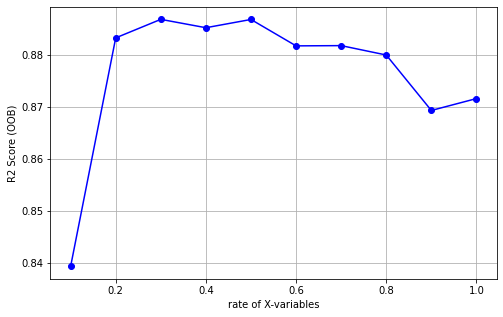

Optimal rate of X-variables: 0.3
Evaluating Training Data
R^2: 0.715, RMSE: 0.075, MAE: 0.055


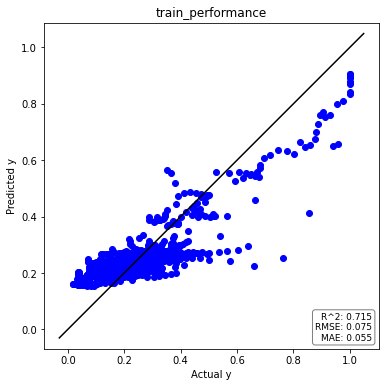

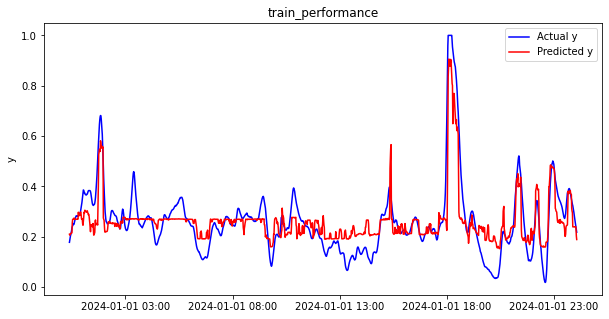

Evaluating Test Data
R^2: 0.543, RMSE: 0.123, MAE: 0.092


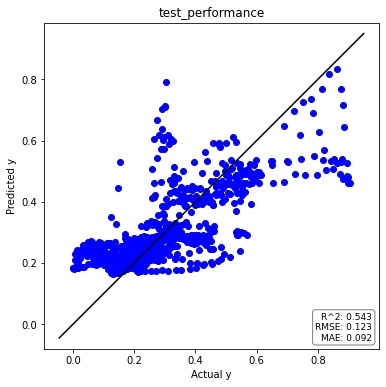

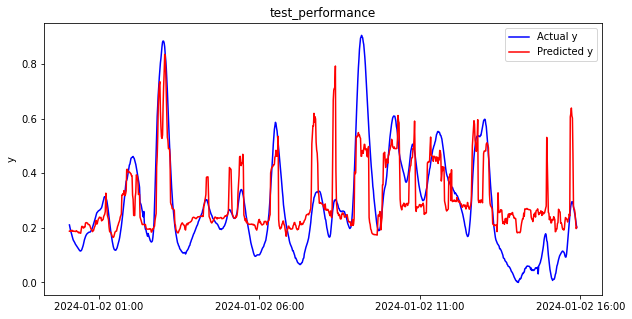

In [25]:
# ランダムフォレスト回帰(ブランク)
optimal_x_variables_rate, rf_final = rt.perform_rf_regression(X, y)

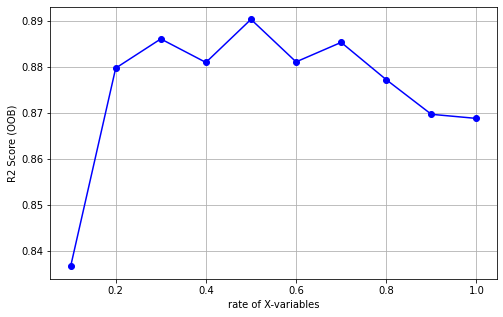

Optimal rate of X-variables: 0.5
Evaluating Training Data
R^2: 0.726, RMSE: 0.074, MAE: 0.054


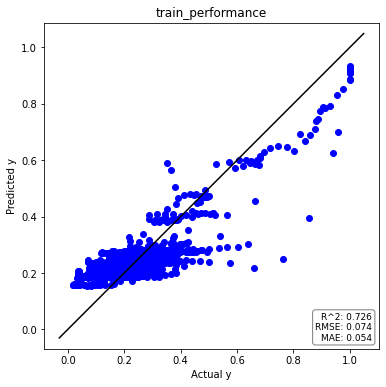

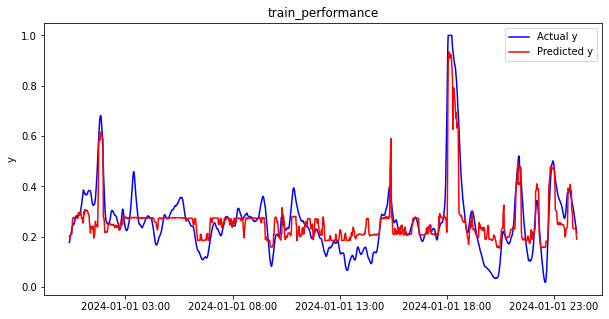

Evaluating Test Data
R^2: 0.563, RMSE: 0.121, MAE: 0.090


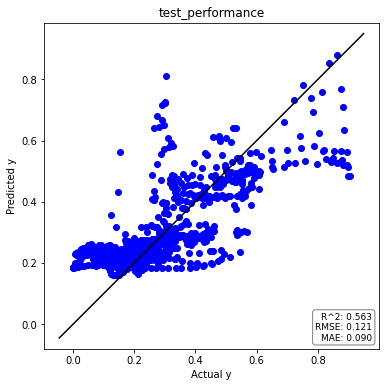

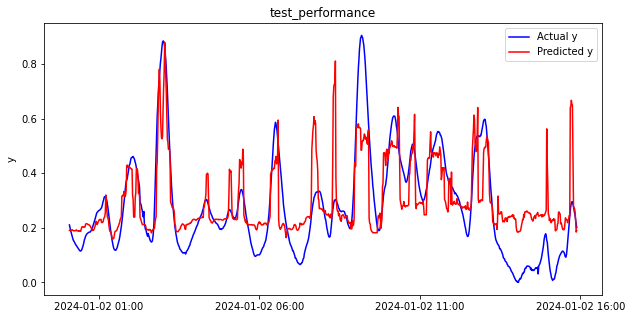

In [26]:
# ランダムフォレスト回帰(Boruta)
optimal_x_variables_rate, rf_final = rt.perform_rf_regression(X_boruta, y)